## 접근 방향

- 데이터 수가 적어 과적합 발생을 우려하여 딥러닝 기반 모델 보다 __통계 기반 모델__을 사용하였습니다
- Sound task 관련 논문을 보면 input data를 __Mel_spectorgram 또는 MFCC__를 사용하는 경우가 많았습니다. __type2__에 대한 모델링을 할 때는 mel_spectrogram/mfcc를 input data로 사용하여도 둘 다 우수한 성능을 보였지만 __type0__의 경우 mfcc를 사용하였을 때 성능이 좋지않아 mel_spectrogram만 사용하였습니다.
- __TSNE__로 train_data를 2차원으로 축소하여 시각화 하였을 때, type에 따른 데이터 분포의 차이를 확인하였고 마찬가지로 type에 따라 이상치의 갯수가 다를 수도 있으므로 따로 모델링을 시도하였습니다.
- KNN, LOF, OC-SVM등 일반적인 모델을 사용한 결과를 통해 이상치의 갯수가 적지 않을 것이라 생각하였고 이 경우 __이상치 간의 상관관계__가 높아 거리기반 / 밀도기반의 추정 방식이 성능이 좋지 않을 것이라 가정하여 객체와 객체를 비교하는 척도로 각도 개념을 사용하여 __고차원 공간에서도 일반적인 거리기반 / 밀도기반 이상치 측정 방법보다 좋은 이상치 탐지 성능을 가진 ABOD방식을 선택__하였습니다.

- __ABOD paper : https://www.dbs.ifi.lmu.de/~zimek/publications/KDD2008/KDD08-ABOD.pdf__
- __Deep-SVDD paper : http://proceedings.mlr.press/v80/ruff18a/ruff18a.pdf__

## 방법1

#### [public_score] : 0.9867 / [private_ score] : 0.9915

### Type 0 : ABOD

input data : mel_spectrogram / 
n_neighbors : 6 /
contamination : 0.03

### Type 2 : ABOD

input data : mel_spectrogram /
n_neighbors : 6 /
contamination : 0.015

## 방법2

#### [public_score] : 0.9911 / [private_ score] : 0.9905

### Type 0 : ABOD

input data : mel_spectrogram / 
n_neighbors : 6 /
contamination : 0.03

### Type 2 : SVDD

input data : mfcc / 
gamma : 0.001

## 최종 제출

__방법1과 방법2를 합쳐__ 두 개의 모델이 공통적으로 이상치라고 판단하는 case에 대해서만 이상치로 최종 선택하게 하였습니다. 

### [public_score] : 0.9911 / [private_ score] : 0.9933

### Type 0 : ABOD

input data : mel_spectrogram / 
n_neighbors : 6 /
contamination : 0.03

### Type 2 : ABOD + SVDD

input data : mel_spectrogram / 
n_neighbors : 6 /
contamination : 0.015

input data : mfcc / 
gamma : 0.001

## Code Review

## Setting

In [94]:
import warnings
warnings.filterwarnings(action='ignore')

import random
import pandas as pd
import numpy as np
import math
import os
from tqdm.auto import tqdm
from glob import glob
import librosa
import librosa.display

from sklearn.manifold import TSNE
from pyod.models.abod import ABOD
from pyod.models.deep_svdd import DeepSVDD

import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(1234)

## Load files

In [13]:
train_path = glob('./train/*')
train_path.sort()
test_path = glob('./test/*')
test_path.sort()

## Plots

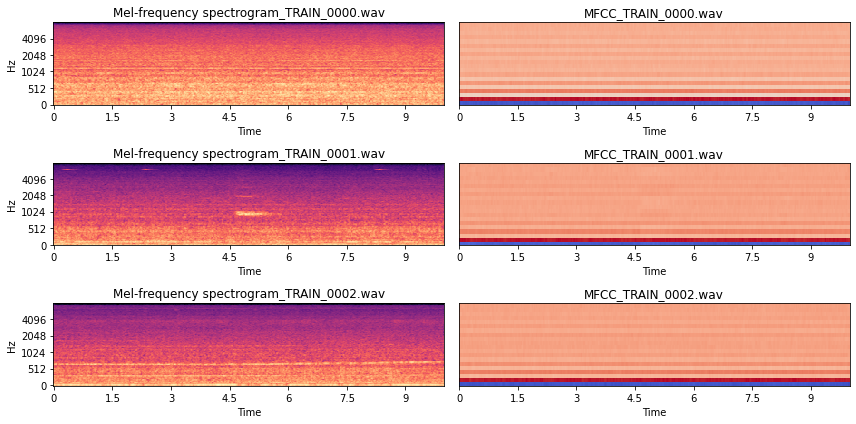

In [84]:
plt.figure(figsize=(12,6))
for i in range(6):
    name = train_path[i//2].split('/')[-1]
    y, sr = librosa.load(train_path[i//2])
    if i%2==0:
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        plt.subplot(3,2,i+1)
        librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.title(f'Mel-frequency spectrogram_{name}')
    
    if i%2 == 1:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        plt.subplot(3,2,i+1)
        librosa.display.specshow(mfccs, x_axis='time')
        plt.title(f'MFCC_{name}')
        plt.tight_layout()

## Get features

In [85]:
def get_feature_mel(path):
    features = []
    for i in tqdm(path):
        data, sr = librosa.load(i, 16000)
        n_fft = 2048
        win_length = 2048
        hop_length = 1024
        n_mels = 128
 
        D = np.abs(librosa.stft(data, n_fft=n_fft, win_length = win_length, hop_length=hop_length))
        mel = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=n_mels, hop_length=hop_length, win_length=win_length)

    
        m_mel = mel.mean(axis=1)
        features.append(m_mel)
    return np.array(features)

In [86]:
def get_feature_mfcc(path):
    features = []
    for i in tqdm(path):
        data, sr = librosa.load(i, 16000)
 
        mfcc = librosa.feature.mfcc(data, sr=sr, n_mfcc=128)
    
        m_mfcc = mfcc.mean(axis=1)
        features.append(m_mfcc)
    return np.array(features)

In [87]:
train_fan = pd.read_csv('train.csv').iloc[:,2]
test_fan = pd.read_csv('test.csv').iloc[:,2]

In [88]:
train_f0 = get_feature_mfcc(np.array(train_path)[train_fan==0])
train_f2 = get_feature_mfcc(np.array(train_path)[train_fan==2])
test_f0 = get_feature_mfcc(np.array(test_path)[test_fan==0])
test_f2 = get_feature_mfcc(np.array(test_path)[test_fan==2])

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

In [90]:
train_0 = get_feature_mel(np.array(train_path)[train_fan==0])
train_2 = get_feature_mel(np.array(train_path)[train_fan==2])
test_0 = get_feature_mel(np.array(test_path)[test_fan==0])
test_2 = get_feature_mel(np.array(test_path)[test_fan==2])

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

In [91]:
train_all = get_feature_mel(np.array(train_path))
test_all = get_feature_mel(np.array(test_path))

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

## Trainset의 분포

<AxesSubplot:xlabel='com1', ylabel='com2'>

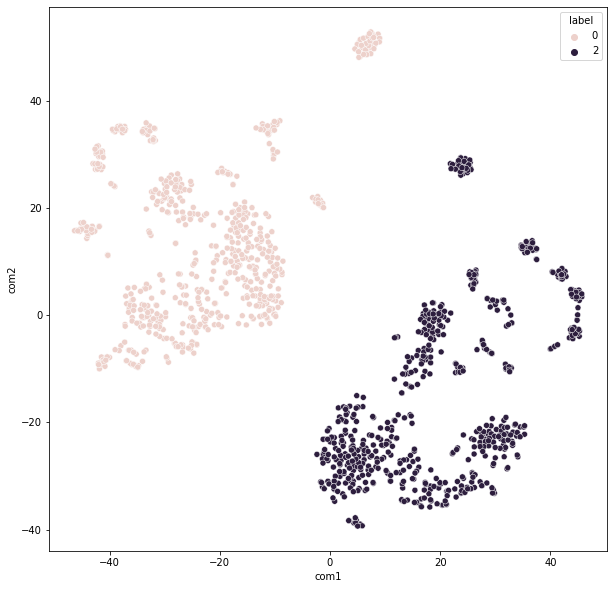

In [98]:
np.random.seed(160)
tsne = TSNE(n_components=2)
tt = tsne.fit_transform(train_all)

tt_df = pd.DataFrame(tt, columns=['com1', 'com2'])
tt_df['label'] = train_fan

sns.set_palette('deep')
plt.figure(figsize=(10,10))
sns.scatterplot(x='com1', y='com2', hue='label', data=tt_df)

## Modeling

## Deep SVDD

In [99]:
svdd = DeepSVDD(contamination=0.01)
svdd.fit(train_2)
svdd_label = svdd.predict(test_2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8192      
_________________________________________________________________
net_output (Dense)           (None, 32)                2048      
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 32)                0         
_________________________________________________________________
tf.math.pow_1 (TFOpLambda)   (None, 32)                0         
_________________________________________________________________
tf.math.reduce_sum_1 (TFOpLa (None,)                   0         
_________________________________________________________________
tf.math.reduce_mean_1 (TFOpL ()                        0   

18/18 [==============================] - 0s 3ms/step - loss: 0.8249 - val_loss: 1.2116
Epoch 68/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8171 - val_loss: 1.1905
Epoch 69/100
18/18 [==============================] - 0s 2ms/step - loss: 0.8065 - val_loss: 1.2241
Epoch 70/100
18/18 [==============================] - 0s 2ms/step - loss: 0.8085 - val_loss: 1.1688
Epoch 71/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7994 - val_loss: 1.1414
Epoch 72/100
18/18 [==============================] - 0s 2ms/step - loss: 0.8009 - val_loss: 1.1516
Epoch 73/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7875 - val_loss: 1.1255
Epoch 74/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7942 - val_loss: 1.1980
Epoch 75/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8219 - val_loss: 1.1815
Epoch 76/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8015 - val_loss: 1.1082
Epoch 77/100


## ABOD

### Type 0

In [100]:
angle_0 = ABOD(n_neighbors=6, contamination=0.03)
angle_0.fit(train_0)
type0_label = angle_0.predict(test_0)

### Type 2

In [101]:
angle_2 = ABOD(n_neighbors=6, contamination=0.03)
angle_2.fit(train_2)
abod_label = angle_2.predict(test_2)

## Ensemble

In [102]:
type2_label = np.where((svdd_label + abod_label)<=1, 0, 1)

In [103]:
label = np.zeros(len(test_all), dtype='int')

In [104]:
label[test_fan==0] = type0_label
label[test_fan==2] = type2_label

## Result

### Type 0

<AxesSubplot:title={'center':'Type_2'}, xlabel='com1', ylabel='com2'>

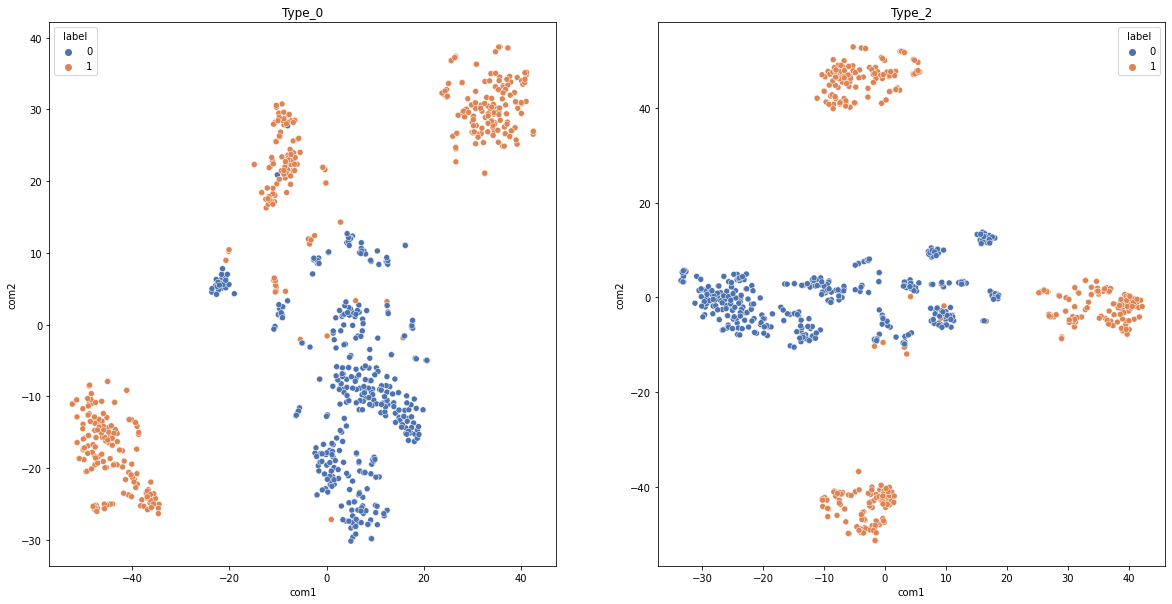

In [117]:
plt.figure(figsize=(20,10))
np.random.seed(170)

tsne = TSNE(n_components=2)
tt = tsne.fit_transform(test_0)
tt_df = pd.DataFrame(tt, columns=['com1', 'com2'])
tt_df['label'] = type0_label
plt.subplot(1,2,1)
plt.title('Type_0')
sns.set_palette('deep')
sns.scatterplot(x='com1', y='com2', hue='label', data=tt_df)

tsne = TSNE(n_components=2)
tt = tsne.fit_transform(test_2)
tt_df = pd.DataFrame(tt, columns=['com1', 'com2'])
tt_df['label'] = type2_label
plt.subplot(1,2,2)
plt.title('Type_2')
sns.set_palette('deep')
sns.scatterplot(x='com1', y='com2', hue='label', data=tt_df)

## Summit

In [43]:
submit = pd.read_csv('./final_summit.csv')

In [44]:
submit['LABEL'] = label
submit.head()

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,1
3,TEST_0003,1
4,TEST_0004,1


In [45]:
submit.to_csv('./summit.csv', index=False)